/tmp/ipykernel_99/3066796490.py:33: RuntimeWarning: divide by zero encountered in log
  log_tau_proposed = np.log(current_tau) + np.random.normal(0, step_tau)
/tmp/ipykernel_99/3066796490.py:37: RuntimeWarning: divide by zero encountered in log
  log_lik_proposed = (n/2)*np.log(tau_proposed) - 0.5 * tau_proposed * sum_sq
/tmp/ipykernel_99/3066796490.py:38: RuntimeWarning: divide by zero encountered in log
  log_lik_current = (n/2)*np.log(current_tau) - 0.5 * current_tau * sum_sq
/tmp/ipykernel_99/3066796490.py:39: RuntimeWarning: divide by zero encountered in log
  log_prior_proposed = (alpha/2 -1)*np.log(tau_proposed) - (lambda_/2)*tau_proposed
/tmp/ipykernel_99/3066796490.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  log_prior_proposed = (alpha/2 -1)*np.log(tau_proposed) - (lambda_/2)*tau_proposed
/tmp/ipykernel_99/3066796490.py:40: RuntimeWarning: divide by zero encountered in log
  log_prior_current = (alpha/2 -1)*np.log(current_tau) - (lambda_/2)*current_ta

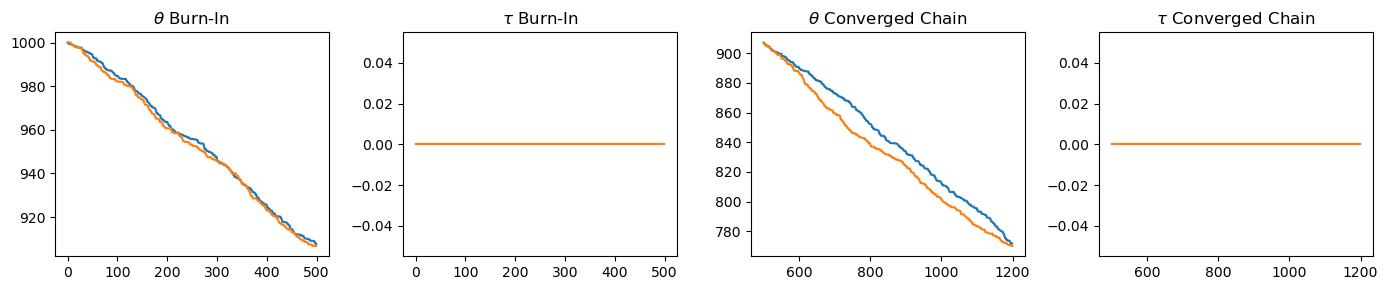

In [4]:
# question 1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Data generation
n = 30
np.random.seed(42)
x = stats.norm(loc=0, scale=1).rvs(size=n)
x_bar = np.mean(x)
sum_sq_data = np.sum((x - x_bar)**2)

# Hyperparameters
theta0 = 0.0    # Prior mean for theta
tau0 = 1.0      # Prior precision (inverse variance) for theta
alpha = 2.0     # Prior shape for tau
lambda_ = 1.0   # Prior rate for tau

# Metropolis-within-Gibbs parameters
C, G = 2, 10000  # Chains, Gibbs samples
theta = np.zeros((C, G))
tau = np.zeros((C, G))
theta[:, 0] = 1000  # Initialize far from true value

# Tuning parameters for proposals
step_theta = 0.5  # Step size for theta (random walk)
step_tau = 0.1    # Step size for log(tau) (log-normal)

for c in range(C):
    current_theta = theta[c, 0]
    current_tau = tau[c, 0]
    for g in range(1, G):
        # Update tau with log-normal proposal
        log_tau_proposed = np.log(current_tau) + np.random.normal(0, step_tau)
        tau_proposed = np.exp(log_tau_proposed)
        sum_sq = np.sum((x - current_theta)**2)
        # Calculate log-likelihood and prior
        log_lik_proposed = (n/2)*np.log(tau_proposed) - 0.5 * tau_proposed * sum_sq
        log_lik_current = (n/2)*np.log(current_tau) - 0.5 * current_tau * sum_sq
        log_prior_proposed = (alpha/2 -1)*np.log(tau_proposed) - (lambda_/2)*tau_proposed
        log_prior_current = (alpha/2 -1)*np.log(current_tau) - (lambda_/2)*current_tau
        # Jacobian adjustment for log transformation
        log_proposal_ratio = np.log(tau_proposed) - np.log(current_tau)
        log_alpha = (log_lik_proposed + log_prior_proposed - log_lik_current - log_prior_current) + log_proposal_ratio
        if np.log(np.random.rand()) < log_alpha:
            current_tau = tau_proposed
        tau[c, g] = current_tau
        
        # Update theta with normal proposal
        theta_proposed = np.random.normal(current_theta, step_theta)
        sum_sq_proposed = np.sum((x - theta_proposed)**2)
        sum_sq_current = np.sum((x - current_theta)**2)
        # Calculate log-likelihood and prior
        log_lik_proposed_theta = -0.5 * current_tau * (sum_sq_proposed - sum_sq_current)
        log_prior_proposed_theta = stats.norm(loc=theta0, scale=1/np.sqrt(tau0)).logpdf(theta_proposed)
        log_prior_current_theta = stats.norm(loc=theta0, scale=1/np.sqrt(tau0)).logpdf(current_theta)
        log_alpha_theta = log_lik_proposed_theta + (log_prior_proposed_theta - log_prior_current_theta)
        if np.log(np.random.rand()) < log_alpha_theta:
            current_theta = theta_proposed
        theta[c, g] = current_theta

# Plotting
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
burn = 500
demo = 1200
titles = ["$\\theta$ Burn-In", "$\\tau$ Burn-In", 
          "$\\theta$ Converged Chain", "$\\tau$ Converged Chain"]
for i in range(4):
    ax[i].set_title(titles[i])

for c in range(C):
    ax[0].plot(theta[c, :burn])
    ax[1].plot(tau[c, :burn])
    ax[2].plot(np.arange(burn, demo), theta[c, burn:demo])
    ax[3].plot(np.arange(burn, demo), tau[c, burn:demo])

plt.tight_layout()
plt.show()


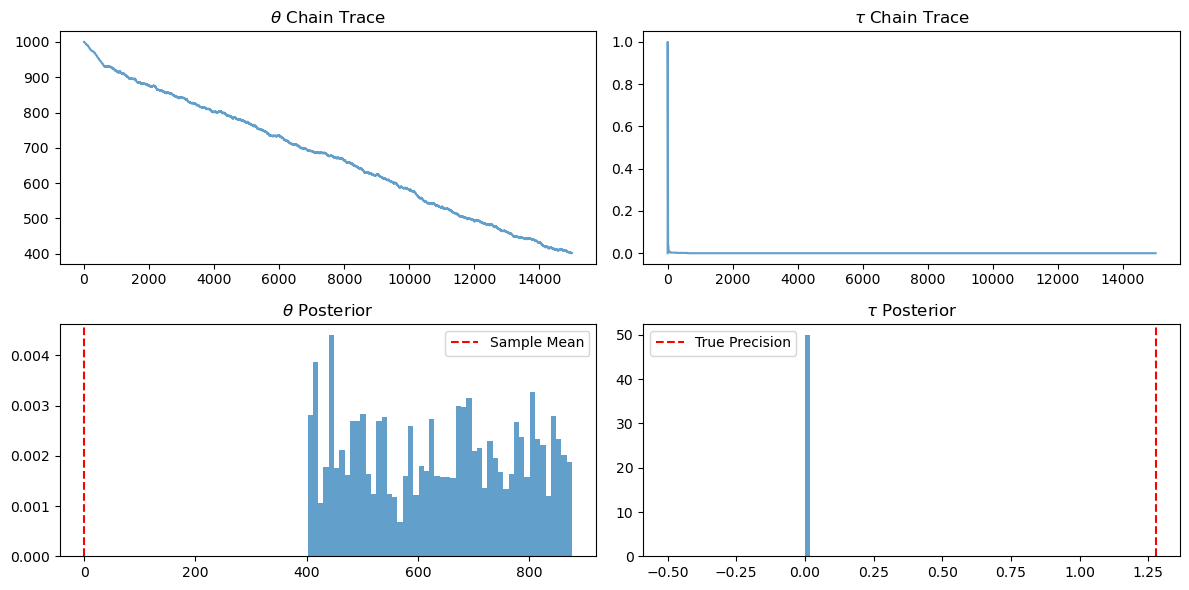

Tau acceptance rate: 0.10%
Theta acceptance rate: 87.69%


In [7]:
# question 2
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Data generation
np.random.seed(42)
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)
x_bar = np.mean(x)

# Hyperparameters
theta0 = 0.0      # Prior location for theta (Laplace center)
b_scale = 1.0     # Prior scale for theta (Laplace)
alpha = 2.0       # Prior shape for tau
lambda_ = 1.0     # Prior rate for tau

# Metropolis-within-Gibbs parameters
C, G = 2, 15000   # Chains, Gibbs samples
theta = np.zeros((C, G))
tau = np.zeros((C, G))
theta[:, 0] = 1000  # Initialize far from true value

# Tuning parameters
s_tau = 0.2       # Scale for tau's truncated normal proposal
step_theta = 0.3  # Step size for theta's normal proposal

for c in range(C):
    current_theta = theta[c, 0]
    current_tau = 1.0  # Initialize tau
    for g in range(1, G):
        # ======== Update tau with truncated normal proposal ========
        a = -current_tau/s_tau  # Lower bound in standard normal space
        tau_proposed = stats.truncnorm(a=a, b=np.inf, 
                                     loc=current_tau, 
                                     scale=s_tau).rvs()
        
        # Calculate acceptance ratio components
        # Likelihood terms
        ll_current = 0.5*n*np.log(current_tau) - 0.5*current_tau*np.sum((x - current_theta)**2)
        ll_proposed = 0.5*n*np.log(tau_proposed) - 0.5*tau_proposed*np.sum((x - current_theta)**2)
        
        # Prior terms (gamma prior for tau)
        prior_current = (alpha/2 -1)*np.log(current_tau) - (lambda_/2)*current_tau
        prior_proposed = (alpha/2 -1)*np.log(tau_proposed) - (lambda_/2)*tau_proposed
        
        # Proposal density ratio (truncated normal is asymmetric)
        # Current proposal density
        q_current_to_proposed = stats.truncnorm(
            a=a, b=np.inf, 
            loc=current_tau, scale=s_tau
        ).pdf(tau_proposed)
        
        # Reverse proposal density
        a_rev = -tau_proposed/s_tau
        q_proposed_to_current = stats.truncnorm(
            a=a_rev, b=np.inf,
            loc=tau_proposed, scale=s_tau
        ).pdf(current_tau)
        
        log_alpha = (ll_proposed + prior_proposed) - (ll_current + prior_current)
        log_alpha += np.log(q_proposed_to_current) - np.log(q_current_to_proposed)
        
        if np.log(np.random.rand()) < log_alpha:
            current_tau = tau_proposed
        tau[c, g] = current_tau

        # ======== Update theta with Laplace prior ========
        theta_proposed = np.random.normal(current_theta, step_theta)
        
        # Calculate acceptance ratio
        # Likelihood terms
        ll_prop_theta = -0.5*current_tau*np.sum((x - theta_proposed)**2)
        ll_curr_theta = -0.5*current_tau*np.sum((x - current_theta)**2)
        
        # Laplace prior terms
        prior_prop = -np.abs(theta_proposed - theta0)/b_scale
        prior_curr = -np.abs(current_theta - theta0)/b_scale
        
        log_alpha_theta = (ll_prop_theta + prior_prop) - (ll_curr_theta + prior_curr)
        
        if np.log(np.random.rand()) < log_alpha_theta:
            current_theta = theta_proposed
        theta[c, g] = current_theta

# Plotting results
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
burn = 2000
samples = slice(burn, None)

# Trace plots
ax[0,0].plot(theta[0], alpha=0.7)
ax[0,0].set_title(r"$\theta$ Chain Trace")
ax[0,1].plot(tau[0], alpha=0.7)
ax[0,1].set_title(r"$\tau$ Chain Trace")

# Posterior distributions
ax[1,0].hist(theta[0,samples], bins=50, density=True, alpha=0.7)
ax[1,0].axvline(x_bar, c='r', linestyle='--', label='Sample Mean')
ax[1,0].set_title(r"$\theta$ Posterior")
ax[1,0].legend()

ax[1,1].hist(tau[0,samples], bins=50, density=True, alpha=0.7)
true_precision = 1/(np.std(x)**2)
ax[1,1].axvline(true_precision, c='r', linestyle='--', label='True Precision')
ax[1,1].set_title(r"$\tau$ Posterior")
ax[1,1].legend()

plt.tight_layout()
plt.show()

# Acceptance rates
tau_accept = np.mean(np.diff(tau[0]) != 0)
theta_accept = np.mean(np.diff(theta[0]) != 0)
print(f"Tau acceptance rate: {tau_accept:.2%}")
print(f"Theta acceptance rate: {theta_accept:.2%}")

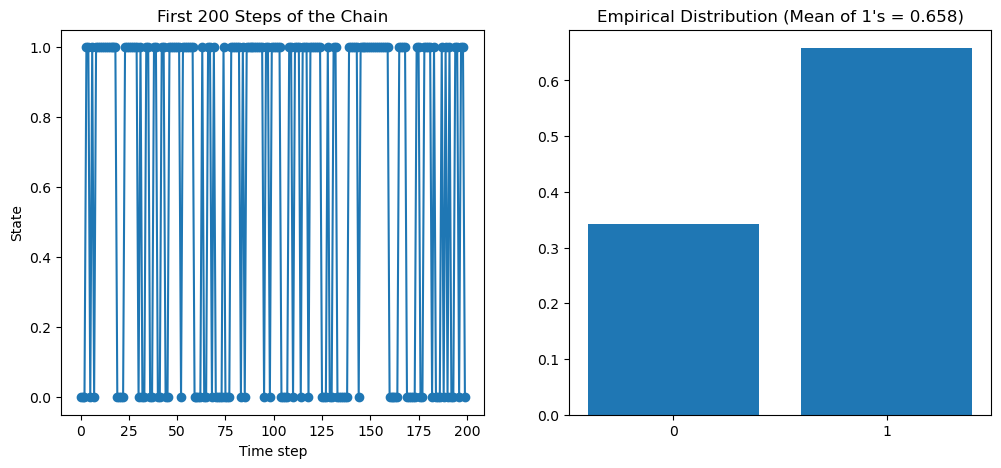

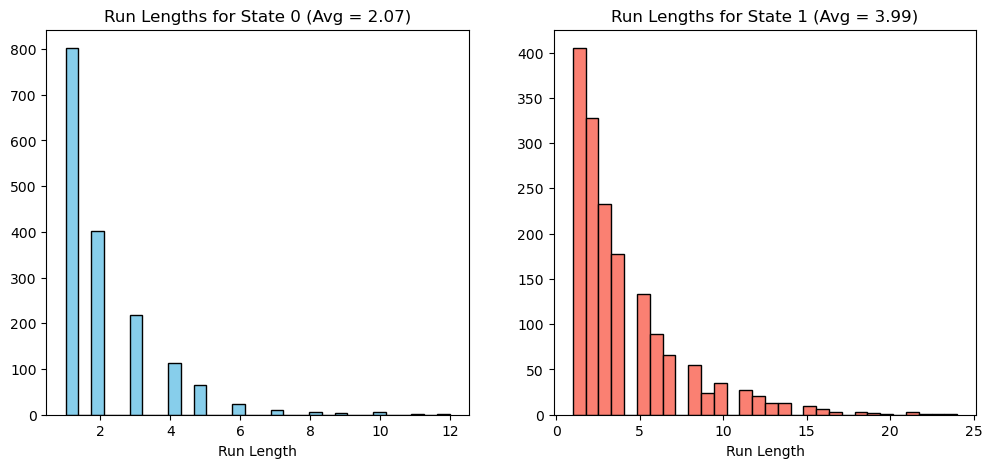

In [10]:
# question 3
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define the transition kernel K
K = np.array([[0.5, 0.25],
              [0.5, 0.75]])

# Simulation parameters
T = 10000   # Total number of steps
s_t = np.zeros(T, dtype=int)  # Initialize chain at state 0

# Simulate the Markov chain
for t in range(1, T):
    u = stats.uniform().rvs()  # Sample a uniform random number in [0,1)
    # Retrieve the probability of transitioning to state 1 from the current state
    p_to_1 = K[1, s_t[t-1]]
    s_t[t] = 1 if u < p_to_1 else 0

# Plot the chain (first 200 steps)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(s_t[:200], marker='o', linestyle='-')
plt.title('First 200 Steps of the Chain')
plt.xlabel('Time step')
plt.ylabel('State')

# Plot the empirical distribution of states
plt.subplot(1, 2, 2)
plt.hist(s_t, bins=[-0.5, 0.5, 1.5], density=True, rwidth=0.8)
plt.xticks([0, 1])
plt.title("Empirical Distribution (Mean of 1's = {:.3f})".format(np.mean(s_t)))
plt.show()

# Compute run lengths for states 0 and 1
state0_run_lengths = []
state1_run_lengths = []
run_length = 1

for t in range(1, T):
    if s_t[t] == s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_lengths.append(run_length)
        else:
            state1_run_lengths.append(run_length)
        run_length = 1

# Plot histograms of run lengths for each state
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(state0_run_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Run Lengths for State 0 (Avg = {:.2f})'.format(np.mean(state0_run_lengths)))
plt.xlabel('Run Length')

plt.subplot(1, 2, 2)
plt.hist(state1_run_lengths, bins=30, color='salmon', edgecolor='black')
plt.title('Run Lengths for State 1 (Avg = {:.2f})'.format(np.mean(state1_run_lengths)))
plt.xlabel('Run Length')

plt.show()
